In [304]:
import jax
from jax import jit
import numpy as np
import jax.numpy as jnp
import sys
sys.path += ['../src/']
import simulator_BC as sim_bc
import estimation_epsilon_BC as est_bc
import jax_estimation_BC as jest_bc
from scipy.special import expit as sigmoid
from scipy.special import expit as logit
import matplotlib.pyplot as plt
import optax
from time import time
import torch
from importlib import reload
import jax.scipy.optimize as joptimize

In [367]:
reload(jest_bc)
reload(est_bc)

<module 'estimation_epsilon_BC' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/notebook/../src/estimation_epsilon_BC.py'>

In [363]:
N, T, edge_per_t = 1000, 2000, 4

epsilon0 = 0.2
epsilon, mu = 0.33, 0.6

rho = 70

In [4]:
X_torch,edges_torch = sim_bc.simulator_stoch(N,T,edge_per_t,epsilon,mu,rho)
X_jax,edges_jax = jest_bc.simulator_stoch_jnp(N,T,edge_per_t,epsilon,mu,rho)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
type(X_torch), type(edges_torch), type(X_jax), type(edges_jax)

(torch.Tensor,
 torch.Tensor,
 jaxlib.xla_extension.Array,
 jaxlib.xla_extension.Array)

In [6]:
type(jnp.array(np.array(X_torch))), type(jnp.array(np.array(edges_torch)))

(jaxlib.xla_extension.Array, jaxlib.xla_extension.Array)

In [7]:
type(torch.from_numpy(np.array(X_jax))), type(torch.from_numpy(np.array(edges_jax)))

(torch.Tensor, torch.Tensor)

In [8]:
X, edges = jest_bc.simulator_stoch_np(N,T,edge_per_t,epsilon,mu,rho)

X_jax, edges_jax = jnp.array(X), jnp.array(edges)
X_torch, edges_torch = torch.from_numpy(X), sim_bc.convert_uvst_edges(torch.from_numpy(edges), T)

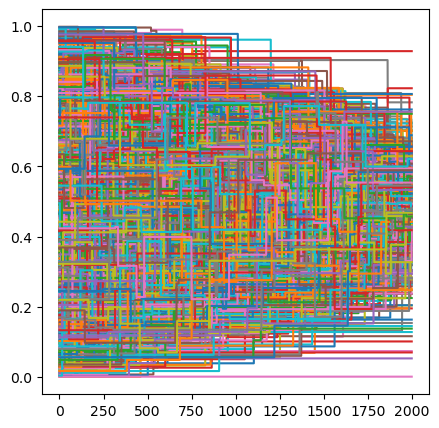

In [9]:
sim_bc.print_opinion_trajectory(X)

### Torch Estimation

In [75]:
history_torch = est_bc.estimation_epsilon_torch(rho, mu, X_torch, edges_torch, epsilon0, min_epochs = 100,
                                                num_epochs = 2000, lr = 0.001, patience = 20, min_delta = 1e-6, return_time = True)


 59%|█████████████████████▉               | 1187/2000 [00:00<00:00, 1442.12it/s]


In [76]:
history_torch["time"]

0.8282556533813477

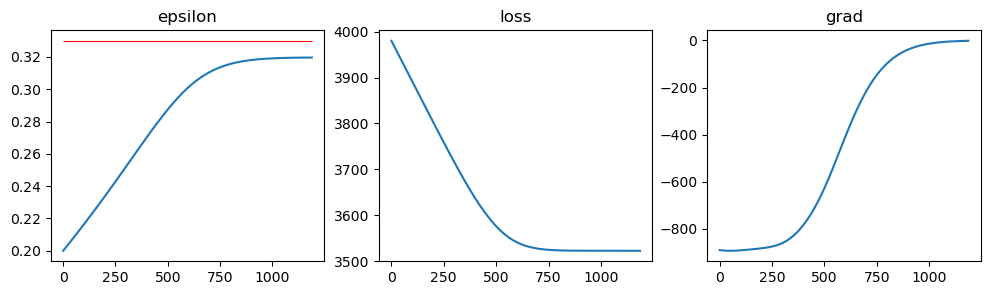

In [77]:
est_bc.print_history(history_torch, epsilon)

### Jax Estimation

In [82]:
history_jax = jest_bc.estimator_BC_jax(rho,mu,X_jax,edges_jax,epsilon0,patience=20,min_delta=1e-6,
                                       min_epochs=100,num_epochs=2000,lr=0.0001,return_time=True)


In [216]:
history_jax["time"]

2.0879952907562256

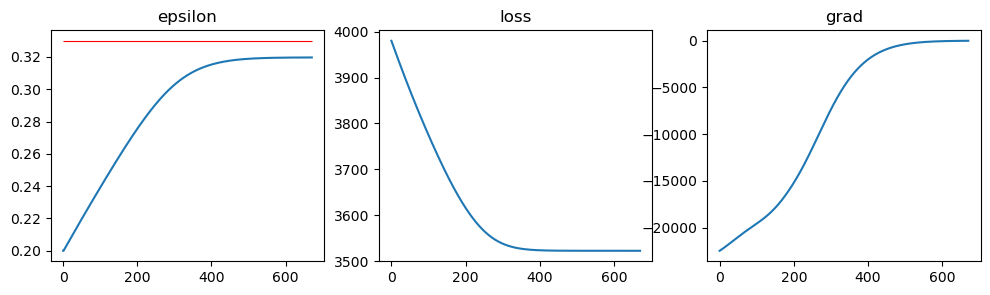

In [84]:
est_bc.print_history(history_jax, epsilon)

### Compare Jax Torch

In [172]:
from itertools import product
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [154]:
def compare_jax_torch(rho, mu, X, edges, epsilon0, patience = 20, min_delta = 1e-6,
                      min_epochs = 100, num_epochs = 2000):
    T = X.shape[0]
    
    X_jax, edges_jax = jnp.array(X), jnp.array(edges)
    X_torch, edges_torch = torch.from_numpy(X), torch.from_numpy(sim_bc.convert_uvst_edges(edges, T))
    
    
    history_torch = est_bc.estimation_epsilon_torch(rho, mu, X_torch, edges_torch, epsilon0, min_epochs = min_epochs,
                                                    num_epochs = num_epochs, lr = 0.001, patience = patience, min_delta = min_delta, 
                                                    return_time = True, hide_progress = True)
    history_jax = jest_bc.estimator_BC_jax(rho, mu, X_jax, edges_jax, epsilon0, min_epochs = min_epochs,
                                           num_epochs = num_epochs, lr = 0.0001, patience = patience, min_delta = min_delta, 
                                           return_time = True, hide_progress = True)
    
    time_torch = history_torch["time"]
    epochs_torch = len(history_torch["epsilon"])
    epsilon_torch = history_torch["epsilon"][-1]
    
    time_jax = history_jax["time"]
    epochs_jax = len(history_jax["epsilon"])
    epsilon_jax = history_jax["epsilon"][-1]
    
    return time_torch, epochs_torch, epsilon_torch, time_jax, epochs_jax, float(epsilon_jax)


In [155]:
N, T, edge_per_t = 1000, 2000, 4

epsilon0 = 0.2
epsilon, mu = 0.11, 0.3

rho = 70

In [156]:
X, edges = jest_bc.simulator_stoch_np(N,T,edge_per_t,epsilon,mu,rho)

In [157]:
time_torch, epochs_torch, epsilon_torch, time_jax, epochs_jax, epsilon_jax = compare_jax_torch(rho, mu, X, edges, epsilon0, 
                                                                                               patience = 20, min_delta = 1e-6,
                                                                                               min_epochs = 100, num_epochs = 2000)

In [158]:
(time_torch, epochs_torch, epsilon_torch), (time_jax, epochs_jax, epsilon_jax)

((1.328702449798584, 2001, 0.10030619843216064),
 (2.192952871322632, 653, 0.09954220056533813))

### Repeat Comparison

In [193]:
def repeated_comparison_jax_torch(mu_list, N_list, T_list, edge_per_t_list, rho = 70, repetitions = 5):
    repeated_comparisons = []
    
    tot_sim = len(mu_list) * len(N_list) * len(T_list) * len(edge_per_t_list) * repetitions
    print("Total simulations", tot_sim)
    for mu, N, T, edge_per_t, _ in tqdm(product(mu_list, N_list, T_list, edge_per_t_list, range(repetitions))):
        epsilon = np.random.random() / 2
        epsilon0 = (np.random.random() / 4) + 0.25
        
        X, edges = jest_bc.simulator_stoch_np(N,T,edge_per_t,epsilon,mu,rho)
        
        time_torch, epochs_torch, epsilon_torch, time_jax, epochs_jax, epsilon_jax = compare_jax_torch(rho, mu, X, edges, epsilon0)
        
        repeated_comparisons.append({"epsilon":epsilon, "epsilon0":epsilon0, "mu":mu, "N":N, "T":T,
                                     "edge_per_t":edge_per_t, "tot_edges": T * edge_per_t, "distance_epsilon0": np.abs(epsilon - epsilon0),
                                     "time":time_torch, "epochs":epochs_torch,
                                     "distance_real": np.abs(epsilon - epsilon_torch), 
                                     "epsilon":epsilon_torch, "method": "torch"})
        repeated_comparisons.append({"epsilon":epsilon, "epsilon0":epsilon0, "mu":mu, "N":N, "T":T,
                                     "edge_per_t":edge_per_t, "tot_edges": T * edge_per_t, "distance_epsilon0": np.abs(epsilon - epsilon0),
                                     "time":time_jax, "epochs":epochs_jax,
                                     "distance_real": np.abs(epsilon - epsilon_jax), 
                                     "epsilon":epsilon_jax, "method": "jax"})
        
    return pd.DataFrame(repeated_comparisons)
        

In [197]:
df = repeated_comparison_jax_torch(mu_list = [0.1, 0.3, 0.5], 
                                   N_list = np.logspace(start = 2, stop = 3.5, num = 4, dtype = int),
                                   T_list = np.logspace(start = 2, stop = 3.5, num = 4, dtype = int), 
                                   edge_per_t_list = [1,5,10], 
                                   repetitions = 2)


Total simulations 288


288it [17:35,  3.67s/it]


<AxesSubplot:xlabel='method', ylabel='time'>

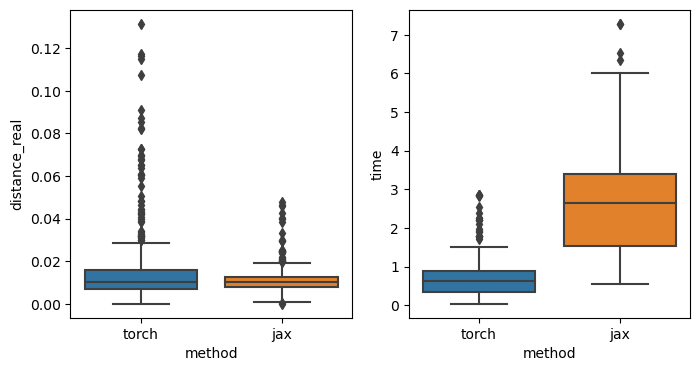

In [198]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [8, 4])
sns.boxplot(data = df, x = "method", y = "distance_real", ax = axes[0])
sns.boxplot(data = df, x = "method", y = "time", ax = axes[1])

<AxesSubplot:xlabel='method', ylabel='time'>

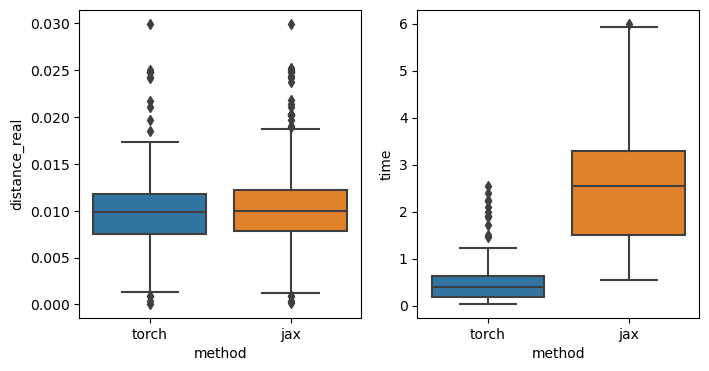

In [202]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [8, 4])
sns.boxplot(data = df.query("epochs < 2001"), x = "method", y = "distance_real", ax = axes[0])
sns.boxplot(data = df.query("epochs < 2001"), x = "method", y = "time", ax = axes[1])

### jax.optimize.minimize

In [338]:
def estimate_jax_optimize(X_jax, edges_jax, rho = 70, epsilon0 = 0.25, return_time = False):
    t0 = time()
    u,v,s,t = edges_jax.T
    T = int(max(t)) + 2
    diff_X_jax = jnp.abs(X_jax[t,u] - X_jax[t,v])
    
    jepsilon0 = jnp.array([epsilon0])
    jtheta0 = jnp_logit(jepsilon0)
    
    @jit
    def jit_compute_loss(jtheta):
        jepsilon = jnp_sigmoid(jtheta)
        return tot_neg_log_likelihood_jnp(edges_jax, rho, jepsilon, T, diff_X_jax)
    
    opt_min = joptimize.minimize(jit_compute_loss, jtheta0, method = "BFGS")
    
    t1 = time()
    
    if return_time:
        return jnp_sigmoid(opt_min.x), t1 - t0
    else:
        return jnp_sigmoid(opt_min.x)


In [339]:
N, T, edge_per_t = 1500, 2500, 2

epsilon0 = 0.4
epsilon, mu = jnp.array([0.42]), 0.2

rho = 70

X_jax,edges_jax = jest_bc.simulator_stoch_jnp(N,T,edge_per_t,epsilon,mu,rho)


In [343]:
epsilon_jopt, time_jopt = estimate_jax_optimize(X_jax, edges_jax, rho, epsilon0, return_time = True)

In [344]:
epsilon_jopt, time_jopt

(Array([0.4106142], dtype=float32), 1.6316261291503906)

In [371]:
def compare_jopt_torch(rho, mu, X, edges, epsilon0, patience = 20, min_delta = 1e-6,
                       min_epochs = 100, num_epochs = 4000):
    T = X.shape[0]
    
    X_jax, edges_jax = jnp.array(X), jnp.array(edges)
    
    X_torch, edges_torch = torch.from_numpy(X), torch.from_numpy(sim_bc.convert_uvst_edges(edges, T))
    
    
    history_torch = est_bc.estimation_epsilon_torch(rho, mu, X_torch, edges_torch, epsilon0, min_epochs = min_epochs,
                                                    num_epochs = num_epochs, lr = 0.001, patience = patience, min_delta = min_delta, 
                                                    return_time = True, hide_progress = True)
    
    epsilon_jopt, time_jopt = jest_bc.estimate_jopt_optimize(X_jax, edges_jax, rho, epsilon0, return_time = True)
    
    time_torch = history_torch["time"]
    epochs_torch = len(history_torch["epsilon"])
    epsilon_torch = history_torch["epsilon"][-1]
    
    
    return time_torch, epochs_torch, epsilon_torch, time_jopt, float(epsilon_jopt)


In [377]:
def repeated_comparison_jopt_torch(mu_list, N_list, T_list, edge_per_t_list, rho = 70, repetitions = 5):
    repeated_comparisons = []
    
    tot_sim = len(mu_list) * len(N_list) * len(T_list) * len(edge_per_t_list) * repetitions
    sim = 0
    print("Total simulation", tot_sim)
    
    for mu, N, T, edge_per_t, _ in tqdm(product(mu_list, N_list, T_list, edge_per_t_list, range(repetitions))):
        sim += 1
        #print(sim)
        
        epsilon = np.random.random() / 2
        epsilon0 = (np.random.random() / 4) + 0.25
        
        X, edges = jest_bc.simulator_stoch_np(N,T,edge_per_t,epsilon,mu,rho)
        
        time_torch, epochs_torch, epsilon_torch, time_jopt, epsilon_jopt = compare_jopt_torch(rho, mu, X, edges, epsilon0)
        
        repeated_comparisons.append({"epsilon_real":epsilon, "epsilon0":epsilon0, "mu":mu, "N":N, "T":T,
                                     "edge_per_t":edge_per_t, "tot_edges": T * edge_per_t, "distance_epsilon0": np.abs(epsilon - epsilon0),
                                     "time":time_torch, "epochs":epochs_torch,
                                     "distance_real": np.abs(epsilon - epsilon_torch), 
                                     "epsilon_estimated":epsilon_torch, "method": "torch"})
        repeated_comparisons.append({"epsilon_real":epsilon, "epsilon0":epsilon0, "mu":mu, "N":N, "T":T,
                                     "edge_per_t":edge_per_t, "tot_edges": T * edge_per_t, "distance_epsilon0": np.abs(epsilon - epsilon0),
                                     "time":time_jopt, "epochs":0,
                                     "distance_real": np.abs(epsilon - epsilon_jopt), 
                                     "epsilon_estimated":epsilon_jopt, "method": "jopt"})
        
    return pd.DataFrame(repeated_comparisons)   

In [380]:
compare_jopt_torch_df = repeated_comparison_jopt_torch(mu_list = [0.1, 0.3, 0.5], 
                                                       N_list = np.logspace(start = 2, stop = 3.5, num = 4, dtype = int),
                                                       T_list = np.logspace(start = 2, stop = 3.5, num = 4, dtype = int), 
                                                       edge_per_t_list = [1,5,10], 
                                                       repetitions = 5)


Total simulation 720


720it [50:41,  4.22s/it]


<AxesSubplot:xlabel='method', ylabel='time'>

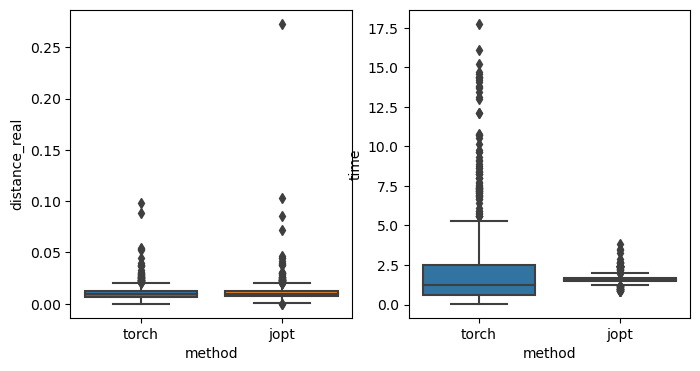

In [383]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [8, 4])
sns.boxplot(data = compare_jopt_torch_df, x = "method", y = "distance_real", ax = axes[0])
sns.boxplot(data = compare_jopt_torch_df, x = "method", y = "time", ax = axes[1])

<AxesSubplot:xlabel='method', ylabel='time'>

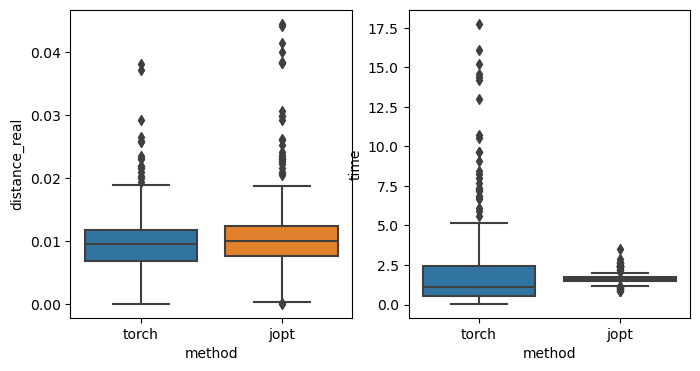

In [389]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [8, 4])
sns.boxplot(data = compare_jopt_torch_df.query("(epsilon0 > 0.15)&(epsilon0 < 0.35)"), x = "method", y = "distance_real", ax = axes[0])
sns.boxplot(data = compare_jopt_torch_df.query("(epsilon0 > 0.15)&(epsilon0 < 0.35)"), x = "method", y = "time", ax = axes[1])

<AxesSubplot:xlabel='epsilon0', ylabel='Count'>

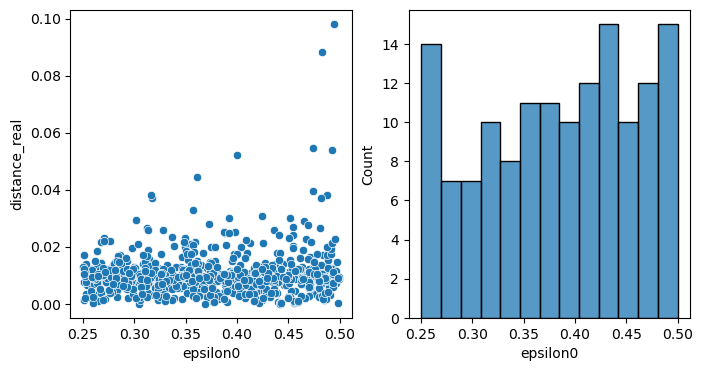

In [402]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [8, 4])
sns.scatterplot(data = compare_jopt_torch_df.query("method == 'torch'"), x = "epsilon0", y = "distance_real", ax = axes[0])
sns.histplot(data = compare_jopt_torch_df.query("epochs == 4001")["epsilon0"], ax = axes[1], bins = 13)


<AxesSubplot:xlabel='epsilon_real', ylabel='distance_real'>

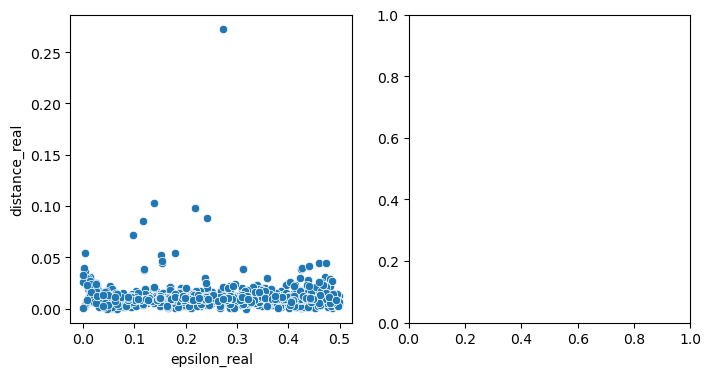

In [405]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [8, 4])

sns.scatterplot(data = compare_jopt_torch_df, x = "epsilon_real", y = "distance_real", ax = axes[0])


In [404]:
compare_jopt_torch_df.columns

Index(['epsilon_real', 'epsilon0', 'mu', 'N', 'T', 'edge_per_t', 'tot_edges',
       'distance_epsilon0', 'time', 'epochs', 'distance_real',
       'epsilon_estimated', 'method'],
      dtype='object')